In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2

In [2]:
plt.rcParams['figure.figsize'] = [6, 8]

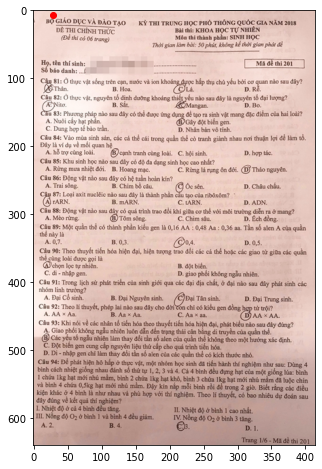

In [3]:
img = cv2.imread('exam1.png')
plt.imshow(img, cmap='gray')
plt.plot(28,7,'ro')

In [4]:
def perspective_transform(img, tmatrix, output_size, flags=cv2.INTER_LINEAR, save_result=None):
    dst = cv2.warpPerspective(img, tmatrix, output_size, flags=flags)
    if save_result:
        cv2.imwrite(save_result, dst)
        print(f"Saved output image to {save_result}")
    plt.figure(figsize=(12, 16))
    plt.subplot(1, 2, 1), plt.imshow(img[...,::-1]), plt.title("original")
    plt.subplot(1, 2, 2), plt.imshow(dst[...,::-1]), plt.title("translated")
    plt.show()

In [5]:
# # Transformation ảnh về cùng một hình thái
# h, w, _ = img.shape
# pts1 = np.float32([[28, 7], [540, 0], [7, 720], [540, 730]])
# pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
# M = cv2.getPerspectiveTransform(pts1, pts2)
# img = cv2.warpPerspective(img, M, (w,h))

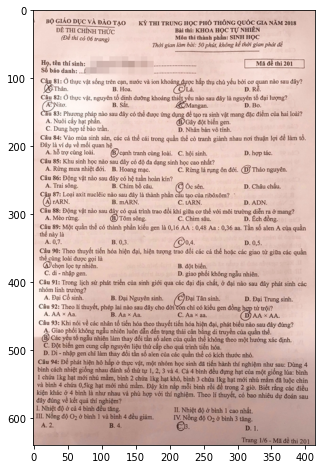

In [6]:
plt.imshow(img)

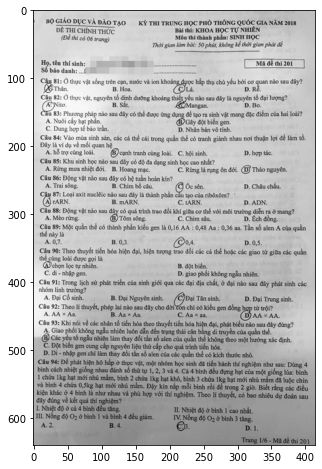

In [7]:
im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray')

In [8]:
# im = cv2.GaussianBlur(img, (5, 5), 0)
# plt.imshow(blurred, cmap='gray')

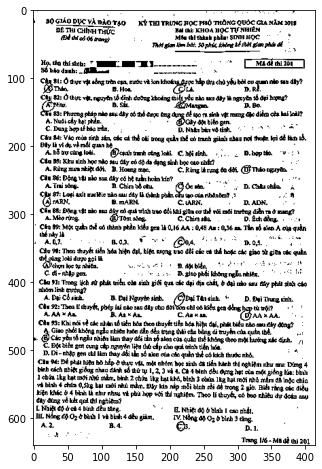

In [9]:
# Chuyển thành ảnh đen trắng bằng Gaussian Threshold 
# (với những phép toán như tìm contour hoặc binary_fill_holes sẽ xử lý hiệu quả hơn trên ảnh đen trắng nên cần có bước này)
im = cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)
plt.imshow(im, cmap='gray')

In [10]:
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# closing = cv2.morphologyEx(255-im, cv2.MORPH_CLOSE, kernel)
# plt.imshow(closing, cmap='gray')

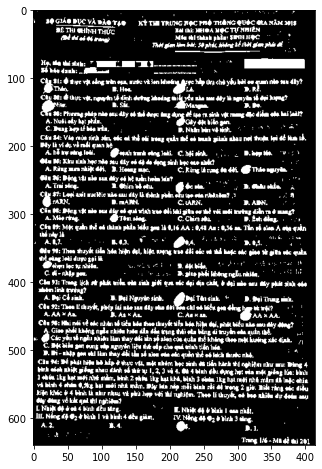

In [12]:
# lấp chỗ trống trong những hình tròn
from scipy.ndimage.morphology import binary_fill_holes

# binary_fill_holes là 1 hàm binary delation
clean_image = binary_fill_holes(255-im)
plt.imshow(clean_image, cmap='gray')

In [13]:
clean_image = np.float32(clean_image)

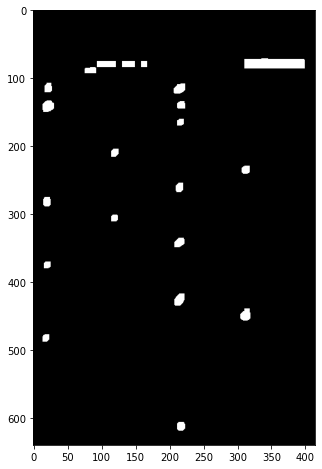

In [14]:
# Opening (mục đích để loại bỏ trường hợp 2 hình tròn dính nhau, hoặc hình tròn dính vào chữ, 
# tuy nhiên opening làm mất dấu khi các hình tròn bị gạch chéo)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
opening = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')

In [15]:
# Lấy ra vị trí các contour (contour là 1 chuỗi tọa độ (x_i, y_) các điểm có cùng độ sáng dọc theo biên của 1 object (t đang hiểu là thế))
contours, _ = cv2.findContours(opening.astype(np.uint8), # pylint: disable=unused-variable
                                  cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_NONE)

# Vẽ contour
obj_image = np.zeros(opening.shape)
for index, cnt in enumerate(contours):
    print(cnt.shape)
    print(cnt)
    cv2.drawContours(opening, [cnt], 0, 255, -1)

(37, 1, 2)
[[[214 606]]

 [[213 607]]

 [[212 608]]

 [[212 609]]

 [[212 610]]

 [[212 611]]

 [[212 612]]

 [[212 613]]

 [[212 614]]

 [[212 615]]

 [[212 616]]

 [[213 617]]

 [[214 618]]

 [[215 618]]

 [[216 618]]

 [[217 618]]

 [[218 618]]

 [[219 618]]

 [[220 618]]

 [[221 617]]

 [[222 616]]

 [[223 615]]

 [[223 614]]

 [[223 613]]

 [[223 612]]

 [[223 611]]

 [[223 610]]

 [[223 609]]

 [[222 608]]

 [[222 607]]

 [[221 606]]

 [[220 606]]

 [[219 606]]

 [[218 606]]

 [[217 606]]

 [[216 606]]

 [[215 606]]]
(33, 1, 2)
[[[ 17 477]]

 [[ 16 478]]

 [[ 15 478]]

 [[ 15 479]]

 [[ 14 480]]

 [[ 14 481]]

 [[ 14 482]]

 [[ 14 483]]

 [[ 14 484]]

 [[ 14 485]]

 [[ 14 486]]

 [[ 14 487]]

 [[ 15 487]]

 [[ 16 487]]

 [[ 17 487]]

 [[ 18 487]]

 [[ 19 487]]

 [[ 20 487]]

 [[ 21 486]]

 [[ 22 485]]

 [[ 23 484]]

 [[ 23 483]]

 [[ 23 482]]

 [[ 23 481]]

 [[ 23 480]]

 [[ 23 479]]

 [[ 23 478]]

 [[ 23 477]]

 [[ 22 477]]

 [[ 21 477]]

 [[ 20 477]]

 [[ 19 477]]

 [[ 18 477]]

Ta có công thức $\frac{4\pi^2r^2}{C^2}=1$ trong đó $C$ là chu vi của hình tròn, giờ ta xác định giá trị $\alpha=\frac{4\pi area}{P^2}$ với $P$ là chu vi của `contour` và nếu giá trị $\alpha$ lớn hơn hoặc bằng `round_thresh` thì ta chấp nhận `contour` đấy là vòng tròn. Ngoài ra trong ảnh các chữ cái cũng có thể tạo thành contour với `area` nhỏ, nên cần phải có một `threshold` nữa cho `area`

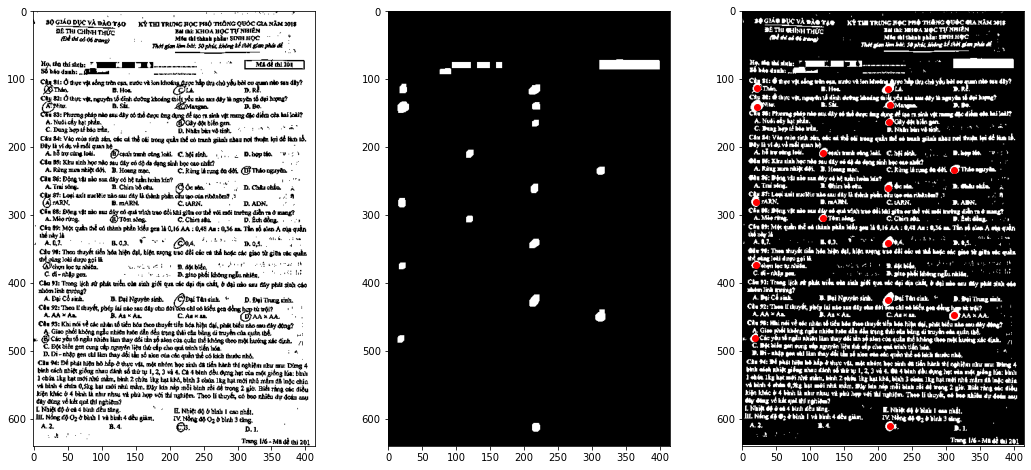

In [16]:
import matplotlib.pyplot as plt

round_thresh = 0.75

plt.figure(figsize=(18,8))
height, width = im.shape
plt.subplot(1, 3, 2), plt.imshow(opening, cmap='gray')
plt.subplot(1, 3, 1), plt.imshow(im.astype(np.uint8), cmap='gray')
plt.subplot(1, 3, 3), plt.imshow(clean_image, cmap='gray')

# plt.subplot(1, 2, 2), plt.imshow(opening, cmap='gray')
# plt.subplot(1, 2, 1), plt.imshow(im.astype(np.uint8), cmap='gray')
areas = []
alphas = []

# print('Object      Area Perimeter Roundness')
for ind, contour in enumerate(contours):
    # tính chu vi của contour
    perimeter = cv2.arcLength(contour, True)
    # tính diện tích của contour
    area = cv2.contourArea(contour)
    areas.append(area)
    
    # nếu như chu vi bằng 0 hoặc area nhỏ hơn threshold thì ta đặt ngay góc alpha = 0
    if perimeter==0 or area<70:
        alpha = 0
    else:
        alpha = 4*np.pi*area/(perimeter**2)
        alphas.append(alpha)

    # Vẽ vòng tròn đỏ tại tâm của contour thỏa mãn điều kiện là vòng tròn
    if alpha > round_thresh:
        moments = cv2.moments(contour)
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        if cy > 110:
            plt.plot(cx, cy, 'ro')

axes = plt.gca()
axes.set_xlim([0, width])
axes.set_ylim([height, 0])

plt.show()

In [ ]:
n = 6
  
alphas.sort()
areas.sort() 
print(areas[-n:]) 
print(alphas[-n:])